In this project I will be trying to predict future weather patterns given historical weather trends in London England.

The data set can be found on kaggle at 

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [103]:
df = pd.read_csv("london_weather.csv")

print(df.info(), end = "\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [104]:
#fixing date for formatting reasons

#creating function as default formatting does not return good
def date_format(x):
    temp = str(x)
    x = str(temp[:4] + "-" + temp[4:6] + "-" + temp[6:])
    return x
    
df["date"] = df["date"].apply(date_format)
df["date"] = pd.to_datetime(df["date"])

df["year"] = pd.to_datetime(df["date"]).dt.year
df["month"] = pd.to_datetime(df["date"]).dt.month
df["day"] = pd.to_datetime(df["date"]).dt.day

df.insert(1, 'year', df.pop("year"))
df.insert(2, 'month', df.pop("month"))
df.insert(3, 'day', df.pop("day"))

df.head()

,date,year,month,day,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979-01-01,1979,1,1,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979-01-02,1979,1,2,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979-01-03,1979,1,3,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979-01-04,1979,1,4,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979-01-05,1979,1,5,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [105]:
#checking for missing data
df.isna().sum()

date                   0
year                   0
month                  0
day                    0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

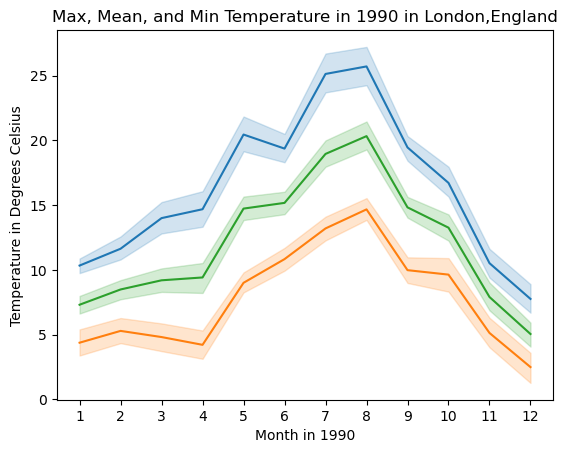

In [106]:
#graphing max,mean, and min temp for a given year
def temp_plot_year(year_of_interest):
    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "max_temp")
    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "min_temp")
    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "mean_temp")

    plt.xlabel(f"Month in {year_of_interest}")
    plt.ylabel(f"Temperature in Degrees Celsius")
    plt.title(f"Max, Mean, and Min Temperature in {year_of_interest} in London,England")
    plt.xticks(range(1, 13))
    plt.show()

temp_plot_year(1990)

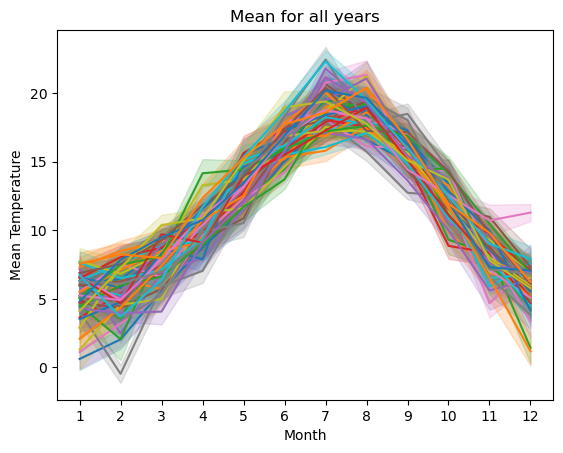

In [107]:
#plotting all average temperatures for all year
year_list = df["year"].unique()

for year in year_list:
    sns.lineplot(data = df[df["year"] == year], x = "month", y = "mean_temp")

plt.xlabel(f"Month")
plt.ylabel(f"Mean Temperature")
plt.title(f"Mean for all years")
plt.xticks(range(1, 13))

plt.show()

In [108]:
#getting the average temperature for each year, and checking for an increase

df_year_avg = df.groupby(df['year']).mean()
df_year_avg = df_year_avg[["max_temp","mean_temp","min_temp"]]
df_year_avg.head()

,max_temp,mean_temp,min_temp
year,,,
1979,13.759178,9.986575,6.217808
1980,14.176230,10.370492,6.587978
1981,14.063562,10.320000,6.574795
1982,15.004658,10.998904,7.006301
1983,15.248767,11.237260,7.227397


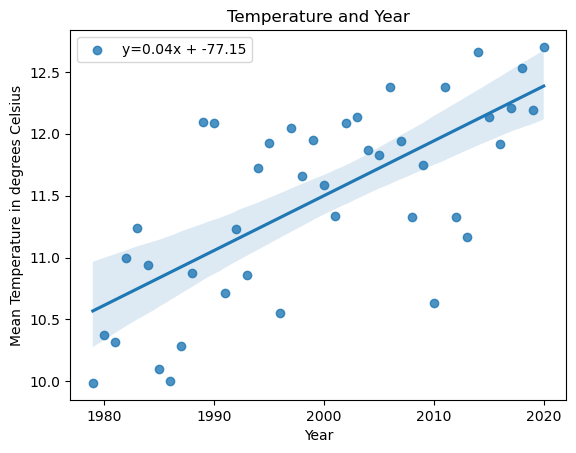

In [111]:
#plotting the line with line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df_year_avg.index, df_year_avg["mean_temp"])

sns.regplot(data = df_year_avg, 
            x = df_year_avg.index, 
            y = "mean_temp",
            label = f'y={slope:.2f}x + {intercept:.2f}')

plt.title('Temperature and Year')
plt.xlabel('Year')
plt.ylabel('Mean Temperature in degrees Celsius')
plt.legend()
plt.show()

Temperature is shown to increase an average of 0.04 degrees each year.